In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

### Read data ###

In [3]:
df = pd.read_csv('./Bitcoin Historical Data.csv')

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,"67,760.8","67,533.9","67,861.0","67,449.6",19.01K,0.34%
1,05/31/2024,"67,530.1","68,352.3","69,018.2","66,676.8",61.51K,-1.21%
2,05/30/2024,"68,354.7","67,631.3","69,504.7","67,138.4",66.84K,1.06%
3,05/29/2024,"67,635.8","68,366.2","68,897.6","67,143.2",52.13K,-1.07%
4,05/28/2024,"68,366.0","69,428.3","69,560.7","67,299.9",71.39K,-1.53%


In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1920 non-null   object
 1   Price     1920 non-null   object
 2   Open      1920 non-null   object
 3   High      1920 non-null   object
 4   Low       1920 non-null   object
 5   Vol.      1920 non-null   object
 6   Change %  1920 non-null   object
dtypes: object(7)
memory usage: 105.1+ KB


In [6]:
def convert_to_number(price_str):
    price_str = price_str.replace(",", "")  # Remove any commas
    if 'K' in price_str:
        return float(price_str.replace('K', '')) * 1000
    elif 'M' in price_str:
        return float(price_str.replace('M', '')) * 1000000
    elif 'B' in price_str:
        return float(price_str.replace('B', '')) * 1000000000
    elif '%' in price_str:
        return float(price_str.replace('%', '')) / 100
    else:
        return float(price_str)

In [7]:
df['Date']  = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)
df['Vol.']   = df['Vol.'].apply(convert_to_number)
df.rename(columns={'Vol.': 'Vol'}, inplace=True)
df['Change %'] = df['Change %'].apply(convert_to_number)
df.rename(columns={'Change %': 'Change'}, inplace=True)
df['Price'] = df['Price'].apply(convert_to_number)
df['Open']  = df['Open'].apply(convert_to_number)
df['High']  = df['High'].apply(convert_to_number)
df['Low']   = df['Low'].apply(convert_to_number)

In [8]:
df.sort_index(ascending=True, inplace=True)

In [9]:
df.head()

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2019-03-01,3821.9,3816.7,3855.8,3816.4,1740000.0,0.0014
2019-03-02,3823.1,3821.9,3843.2,3783.6,1610000.0,0.0003
2019-03-03,3809.5,3823.2,3836.6,3789.7,1510000.0,-0.0036
2019-03-04,3715.9,3809.7,3828.4,3681.8,2850000.0,-0.0245
2019-03-05,3857.2,3715.9,3873.2,3705.7,3820000.0,0.0380


### Descriptive statistc ###

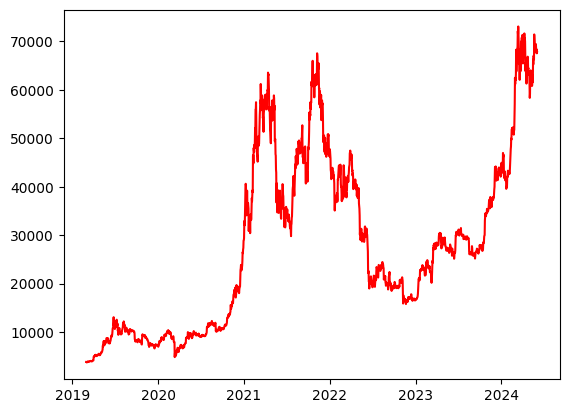

In [10]:
plt.figure()
plt.plot(df["Price"], color='red')
plt.show()

<Axes: >

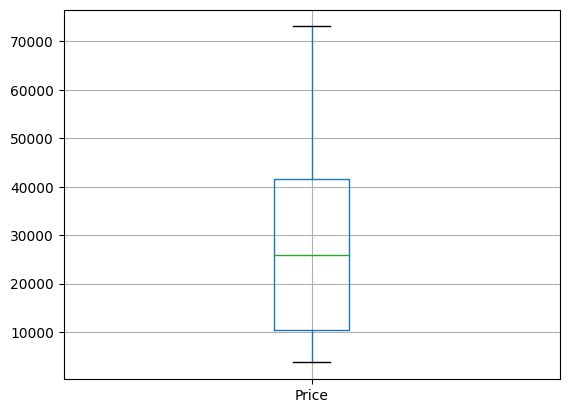

In [11]:
df.boxplot(column=['Price'])

In [12]:
column='Price'
summary = {
    'mean': df[column].mean(),
    'mode': df[column].mode()[0], 
    'std': df[column].std(),
    'var': df[column].var(),
    'kurtosis': kurtosis(df[column]),
    'skewness': skew(df[column]),
    'range': df[column].max() - df[column].min(),
    'min': df[column].min(),
    'max': df[column].max(),
    'sum': df[column].sum(),
    'count': df[column].count(),
    'median': df[column].median()
}

print(f"Summary statistics for column {column}:")
for stat, value in summary.items():
    print(f"{stat}: {value}")


Summary statistics for column Price:
mean: 27920.39703125
mode: 7196.4
std: 17920.190889380498
var: 321133241.51183575
kurtosis: -0.6942125412759332
skewness: 0.5754163357302351
range: 69350.40000000001
min: 3715.9
max: 73066.3
sum: 53607162.3
count: 1920
median: 25933.35


In [13]:
df['Price'].describe()

count     1920.000000
mean     27920.397031
std      17920.190889
min       3715.900000
25%      10435.625000
50%      25933.350000
75%      41491.000000
max      73066.300000
Name: Price, dtype: float64

### Preprocess data ###

In [14]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [15]:
df.head()

,Price,Open,High,Low,Vol,Change,Year,Month,Day
Date,,,,,,,,,
2019-03-01,3821.9,3816.7,3855.8,3816.4,1740000.0,0.0014,2019,3,1
2019-03-02,3823.1,3821.9,3843.2,3783.6,1610000.0,0.0003,2019,3,2
2019-03-03,3809.5,3823.2,3836.6,3789.7,1510000.0,-0.0036,2019,3,3
2019-03-04,3715.9,3809.7,3828.4,3681.8,2850000.0,-0.0245,2019,3,4
2019-03-05,3857.2,3715.9,3873.2,3705.7,3820000.0,0.0380,2019,3,5


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1920 non-null   float64
 1   Open    1920 non-null   float64
 2   High    1920 non-null   float64
 3   Low     1920 non-null   float64
 4   Vol     1920 non-null   float64
 5   Change  1920 non-null   float64
 6   Year    1920 non-null   int64  
 7   Month   1920 non-null   int64  
 8   Day     1920 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 150.0 KB


In [17]:
df.shape

(1920, 9)

### Parameter

In [18]:
window_size = 10
feature_dim = 5

train_size = 0.6
val_size = 0.1
test_size=0.3

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [19]:
train_index = int(len(df)*train_size)
test_index = train_index + int(len(df)*test_size)

print('train index: ',train_index)
print('test index: ',test_index)

train index:  1152
test index:  1728


In [20]:
df_train = df.iloc[:train_index]
df_test  = df[train_index:test_index]
df_val   = df[test_index:]

print('df_train.shape: ',df_train.shape)
print('df_test.shape: ',df_test.shape)
print('df_val.shape: ',df_val.shape)


df_train.shape:  (1152, 9)
df_test.shape:  (576, 9)
df_val.shape:  (192, 9)


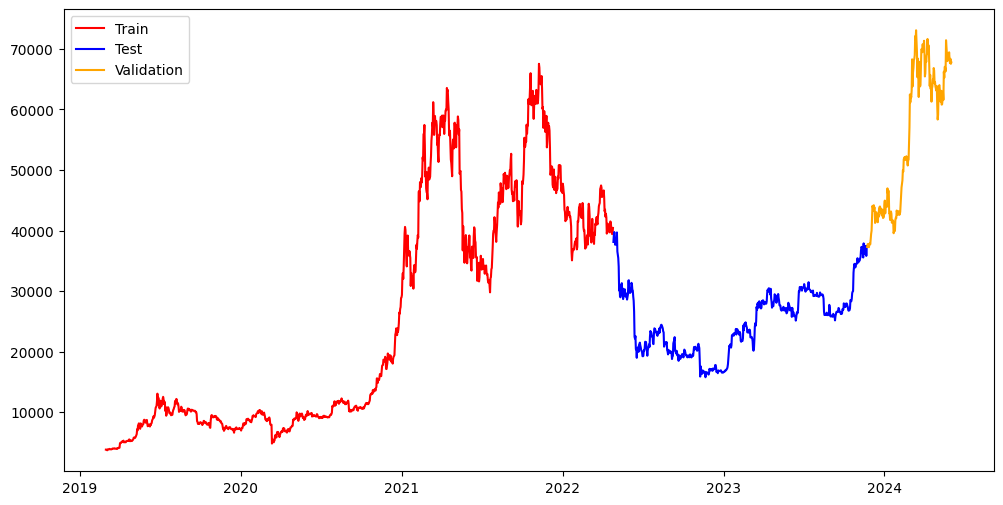

In [21]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Price']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Price']),color='blue' ,label ='Test')
plt.plot(pd.DataFrame(df_val).index.to_list(),pd.DataFrame(df_val['Price']),color ='orange', label ='Validation')
plt.legend()
plt.show()

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_val_scaled = scaler.transform(df_val)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)
df_val_scaled = pd.DataFrame(df_val_scaled,index =df_val.index,columns=df_val.columns)

In [23]:
X_train_scale = df_train_scaled.drop(columns=['Price'])
y_train_scale = df_train_scaled['Price']

X_test_scale  = df_test_scaled.drop(columns=['Price'])
y_test_scale  = df_test_scaled['Price']

X_val_scale = df_val_scaled.drop(columns=['Price'])
y_val_scale = df_val_scaled['Price']

In [24]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)
print('\nX_val_scale shape: ',X_val_scale.shape)
print('y_val_scale shape: ',y_val_scale.shape)

X_train_scale shape:  (1152, 8)
y_train_scale shape:  (1152,)

X_test_scale shape:  (576, 8)
y_test_scale shape:  (576,)

X_val_scale shape:  (192, 8)
y_val_scale shape:  (192,)


In [25]:
# def train_test_split(X_train, y_train,X_test,y_test,test_size, window_size=10):
#     if window_size is not None:
#         X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
#         y_train = y_train[window_size:]
#         X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
#         y_test = y_test[window_size:]
#     return X_train, y_train, X_test, y_test
# X_train, y_train, X_test, y_test=train_test_split(X_train_scale,y_train_scale,X_test_scale,y_test_scale,window_size)
# print('X_train shape: ',X_train.shape)
# print('y_train shape: ',y_train.shape)
# print('X_test shape: ',X_test.shape)
# print('y_test shape: ',y_test.shape)

### Linear Regression ###

In [110]:
X_train_lr = X_train_scale
y_train_lr = y_train_scale

X_test_lr  = X_test_scale
y_test_lr = y_test_scale

X_val_lr = X_val_scale
y_val_lr = y_val_scale

In [99]:
model_LR = LinearRegression()
model_LR.fit(X_train_scale, y_train_scale)

LinearRegression()

In [115]:
pred_test_LR = model_LR.predict(X_test_scale)
pred_val_LR = model_LR.predict(X_val_lr)

In [116]:
mape = mean_absolute_percentage_error(y_test_scale, pred_test_LR)
mae = mean_absolute_error(y_test_scale,pred_test_LR)
mse = mean_squared_error(y_test_scale, pred_test_LR)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.006518108427814249
Mean Absolute Error: 0.0021214706728499605
Root Mean Squared Error: 0.00318425621337898


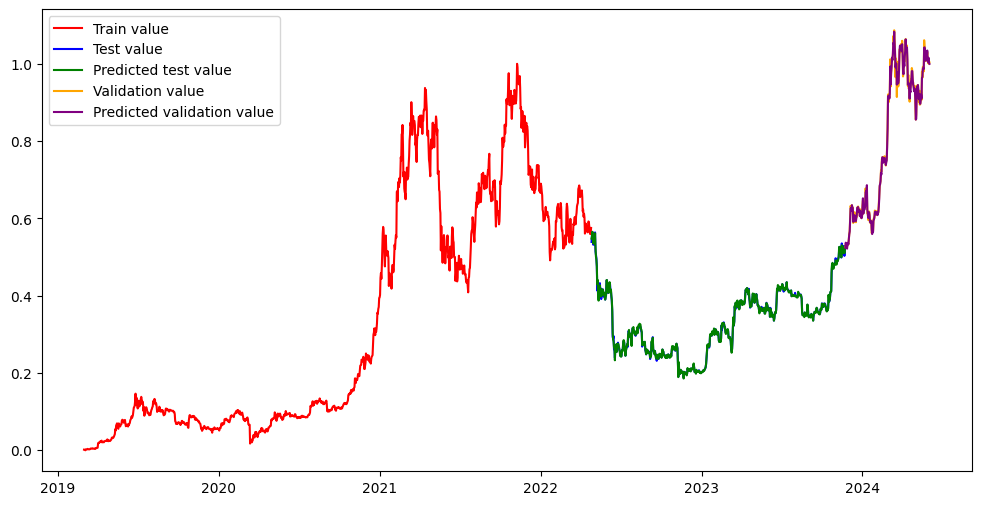

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_lr),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_lr), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LR.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_lr),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LR.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

In [ ]:
model_filename = "model_LR.joblib"
joblib.dump(model_LR, model_filename)

['model_LR.joblib']

### GRU ###

In [126]:
X_train_GRU = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_GRU = y_test_scale.values

X_test_GRU = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_GRU = y_train_scale.values

X_val_GRU = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_GRU = y_val_scale

In [122]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons,  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [123]:
model_GRU = build_GRU_model(
    (X_train_GRU.shape[1], X_train_GRU.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [124]:
history = model_GRU.fit(
    X_train_GRU, y_train_GRU, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [131]:
model_GRU.save('model_GRU.h5')

In [127]:
pred_test_GRU = model_GRU.predict(X_test_GRU)
pred_val_GRU = model_GRU.predict(X_val_GRU)

6/6 [==============================] - 0s 2ms/step


In [128]:
mape = mean_absolute_percentage_error(y_test_GRU, pred_test_GRU)
mae = mean_absolute_error(y_test_GRU,pred_test_GRU)
mse = mean_squared_error(y_test_GRU, pred_test_GRU)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.011790277080000114
Mean Absolute Error: 0.003624994460837564
Root Mean Squared Error: 0.004323025636873949


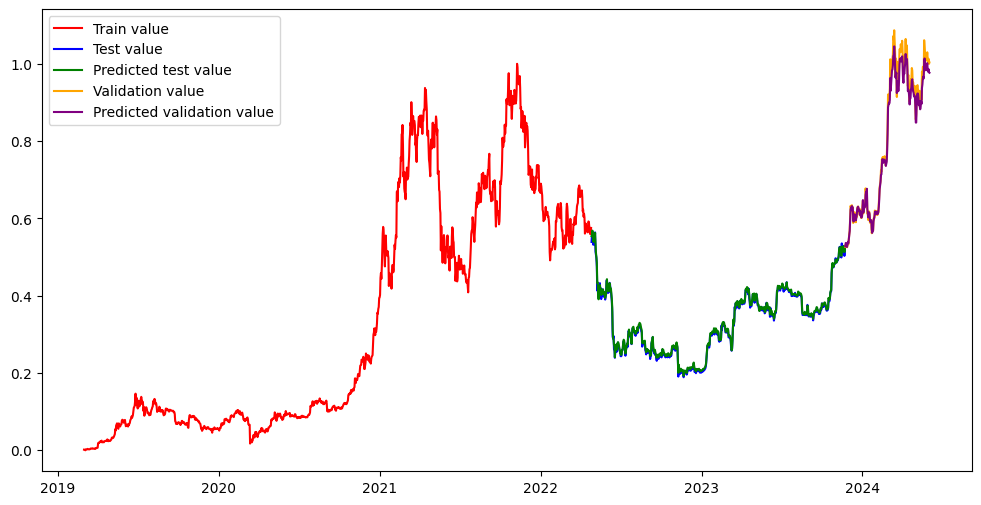

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_GRU),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_GRU), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_GRU.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_GRU),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_GRU.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

### RNN ###

In [131]:
X_train_RNN = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_RNN = y_test_scale.values

X_test_RNN = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_RNN = y_train_scale.values

X_val_RNN = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_RNN = y_val_scale

In [132]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [133]:
model_RNN = build_RNN_model((X_train_RNN.shape[1],X_train_RNN.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [134]:
history = model_RNN.fit(
    X_train_RNN, y_train_RNN, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [139]:
model_RNN.save('model_RNN.h5')

In [135]:
pred_test_RNN = model_RNN.predict(X_test_RNN)
pred_val_RNN = model_RNN.predict(X_val_RNN)

6/6 [==============================] - 0s 2ms/step


In [136]:
mape = mean_absolute_percentage_error(y_test_RNN, pred_test_RNN)
mae = mean_absolute_error(y_test_RNN,pred_test_RNN)
mse = mean_squared_error(y_test_RNN, pred_test_RNN)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.005503104095220441
Mean Absolute Error: 0.0018174378002169475
Root Mean Squared Error: 0.0022259711515596726


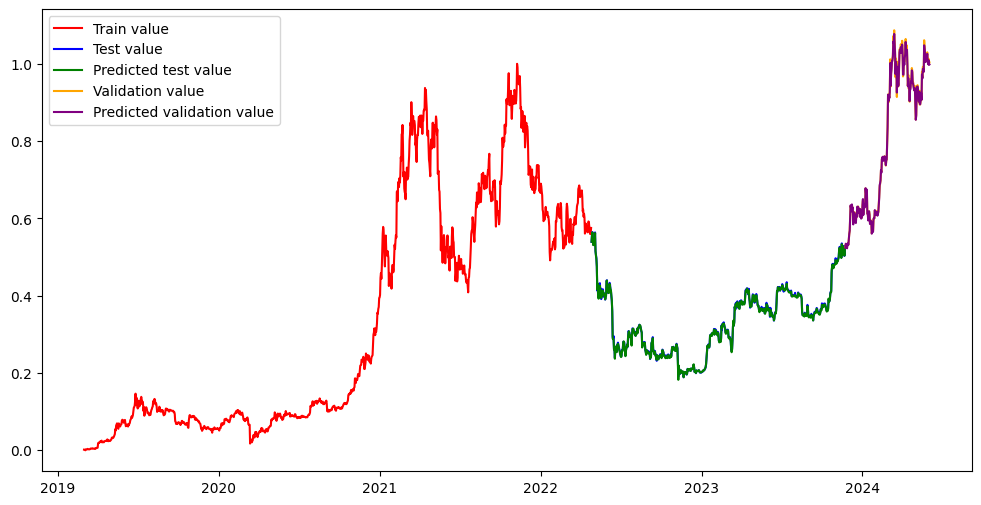

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_RNN),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_RNN), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_RNN.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_RNN),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_RNN.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

### LSTM ###

In [143]:
X_train_LSTM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_test_LSTM  = y_test_scale.values

X_test_LSTM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_train_LSTM  = y_train_scale.values

X_val_LSTM = X_val_scale.values.reshape((X_val_scale.shape[0], 1, X_val_scale.shape[1]))
y_val_LSTM = y_val_scale

In [139]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [140]:
model_LSTM = build_lstm_model(
    (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [141]:
history = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [166]:
model_LSTM.save('model_LSTM.h5')

In [144]:
pred_test_LSTM = model_LSTM.predict(X_test_LSTM)
pred_val_LSTM = model_LSTM.predict(X_val_LSTM)

6/6 [==============================] - 0s 2ms/step


In [145]:
mape = mean_absolute_percentage_error(y_test_LSTM, pred_test_LSTM)
mae = mean_absolute_error(y_test_LSTM,pred_test_LSTM)
mse = mean_squared_error(y_test_LSTM, pred_test_LSTM)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.007919494470927425
Mean Absolute Error: 0.002636413310440393
Root Mean Squared Error: 0.003288630416188514


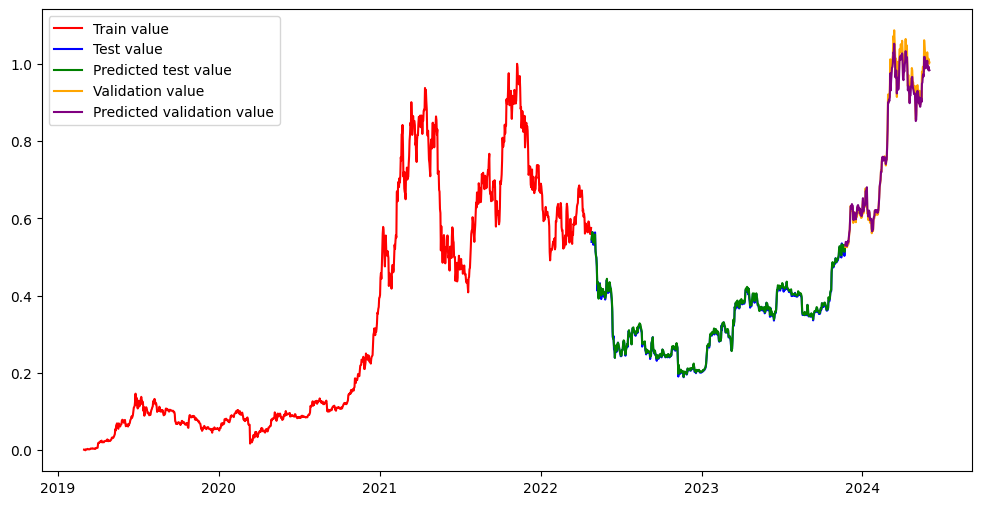

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_LSTM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_LSTM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_LSTM.reshape(-1)), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_LSTM),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_LSTM.reshape(-1)),color='purple', label='Predicted validation value')
plt.legend()
plt.show()

### AUTOFORMER ###

### SARIMAX ###

### STACKING MODELS ###

In [289]:
X_train_SM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_train_SM  = y_train_scale.values
X_test_SM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_test_SM  = y_test_scale.values

In [290]:
print('X_train_SM shape: ',X_train_SM.shape)
print('y_train_SM shape: ',y_train_SM.shape)
print('X_test_SM shape: ',X_test_SM.shape)
print('y_test_SM shape: ',y_test_SM.shape)

X_train_SM shape:  (1828, 1, 8)
y_train_SM shape:  (1828,)
X_test_SM shape:  (92, 1, 8)
y_test_SM shape:  (92,)


In [283]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

Base model 

In [284]:
base_model_GRU = build_GRU_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [285]:
base_model_LSTM = build_lstm_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

First base model (GRU)

In [291]:
prediction_GRU_stacking = pd.DataFrame()
y_test_SM_GRU={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_GRU.predict(X_test_fold)
    y_test_SM_GRU[f'y_test_SM_GRU_{i}'] = base_model_GRU.predict(X_test_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    prediction_GRU_stacking = pd.concat([prediction_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
43/43 [==============================] - 2s 4ms/step - loss: 0.2039
Epoch 2/10
43/43 [==============================] - 0s 4ms/step - loss: 0.1104
Epoch 3/10
43/43 [==============================] - 0s 3ms/step - loss: 0.0882
Epoch 4/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0707
Epoch 5/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0655
Epoch 6/10
43/43 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 7/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0550
Epoch 8/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0502
Epoch 9/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0503
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 2/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0436
Epoch 3/10
43/43 [==============================] - 0s 4ms/step - lo

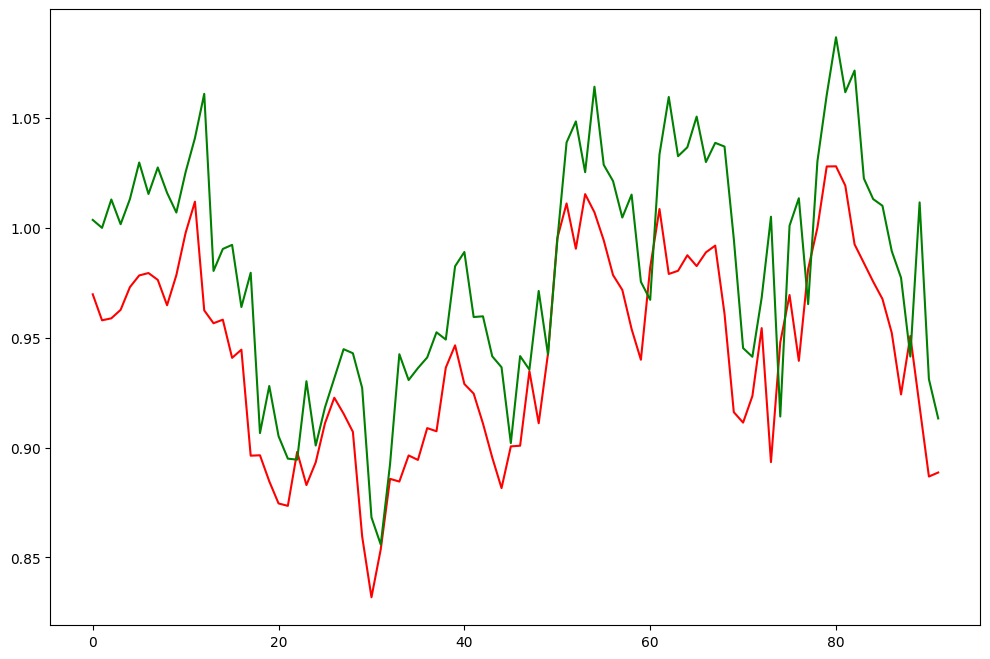

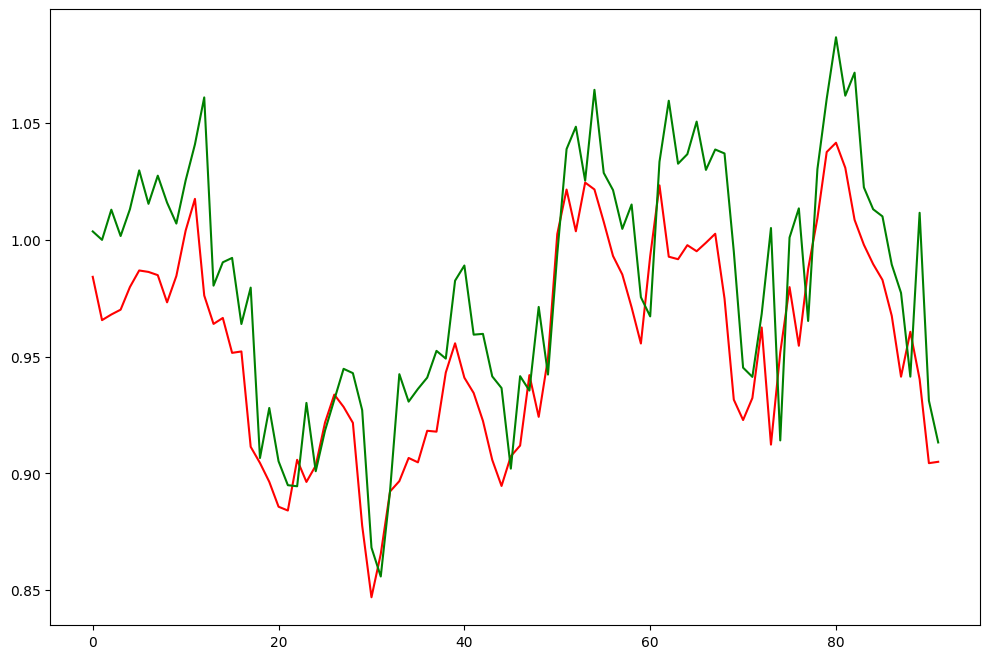

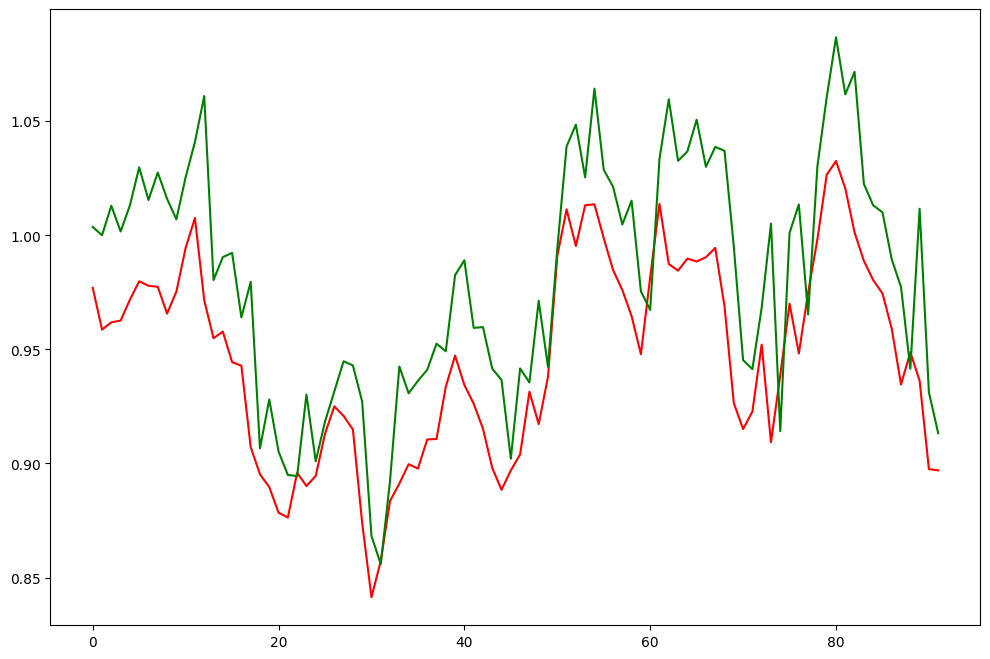

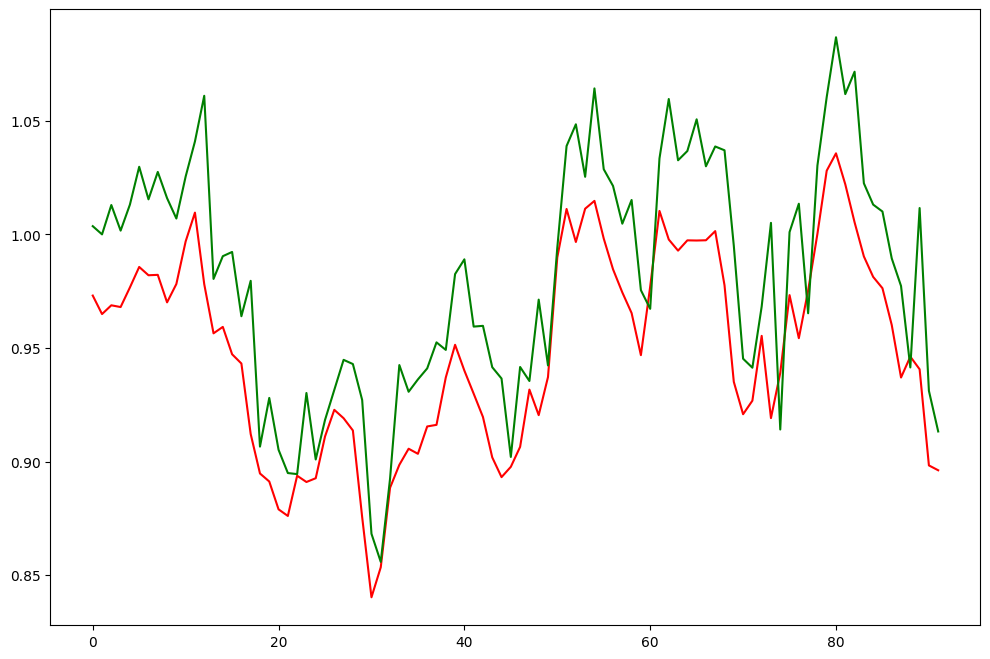

In [294]:
for key in y_test_SM_GRU:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_GRU[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [295]:
num_elements = len(next(iter(y_test_SM_GRU.values())))
test_GRU_average = []
for i in range(num_elements):
    element_sum = sum(y_test_SM_GRU[key][i] for key in y_test_SM_GRU)
    test_GRU_average.append(element_sum / len(y_test_SM_GRU))
test_GRU_average = pd.DataFrame(test_GRU_average)

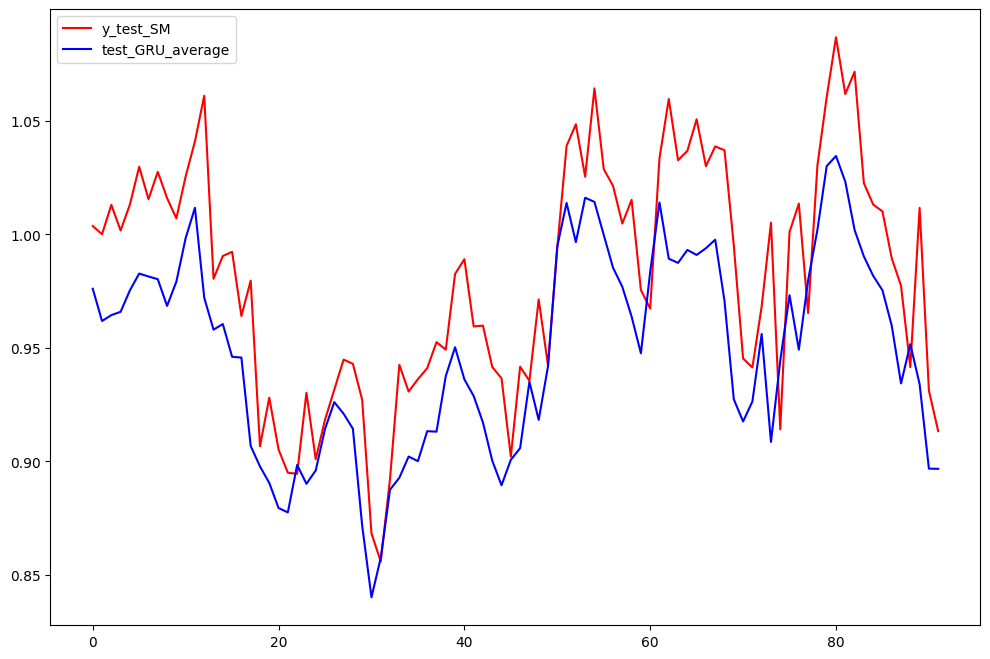

In [329]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_GRU_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

Second base model (LSTM)

In [300]:
prediction_LSTM_stacking = pd.DataFrame()
y_test_SM_LSTM={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_LSTM.predict(X_test_fold)
    y_test_SM_LSTM[f'y_test_SM_LSTM_{i}'] = base_model_LSTM.predict(X_test_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    prediction_LSTM_stacking = pd.concat([prediction_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)

Epoch 1/10
43/43 [==============================] - 2s 4ms/step - loss: 0.2217
Epoch 2/10
43/43 [==============================] - 0s 2ms/step - loss: 0.1239
Epoch 3/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0745
Epoch 4/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 5/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 6/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 7/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 8/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 9/10
43/43 [==============================] - 0s 2ms/step - loss: 0.0425
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Epoch 1/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0379
Epoch 2/10
43/43 [==============================] - 0s 4ms/step - loss: 0.0388
Epoch 3/10
43/43 [==============================] - 0s 3ms/step - lo

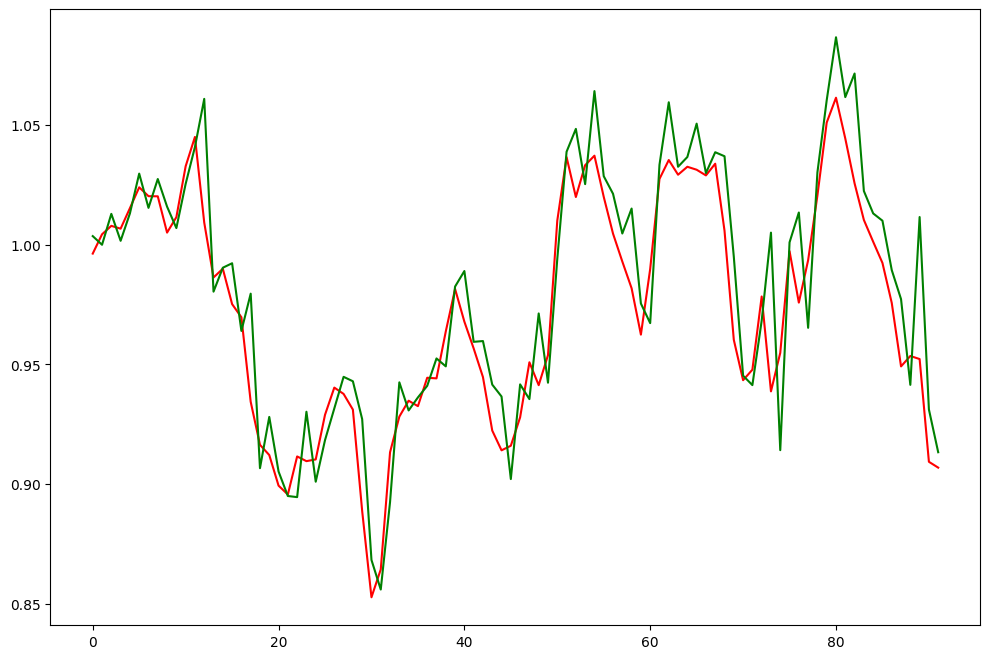

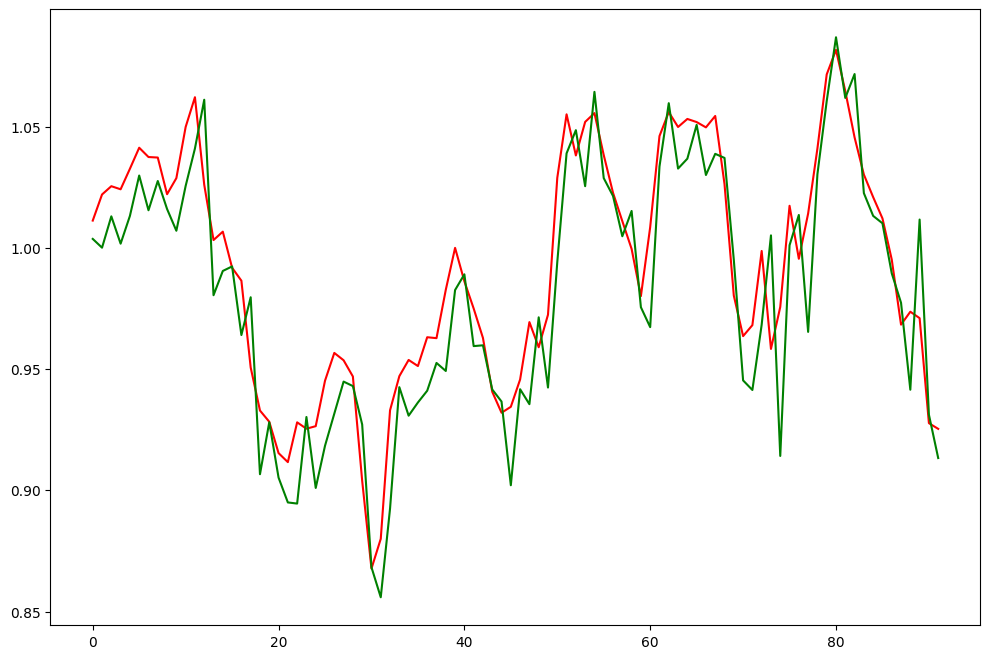

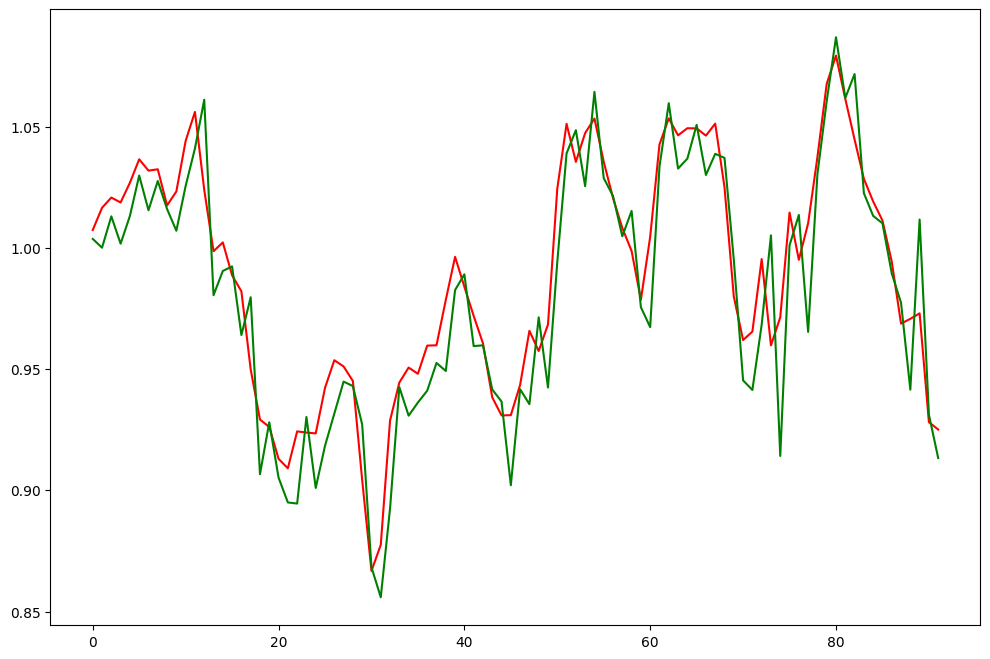

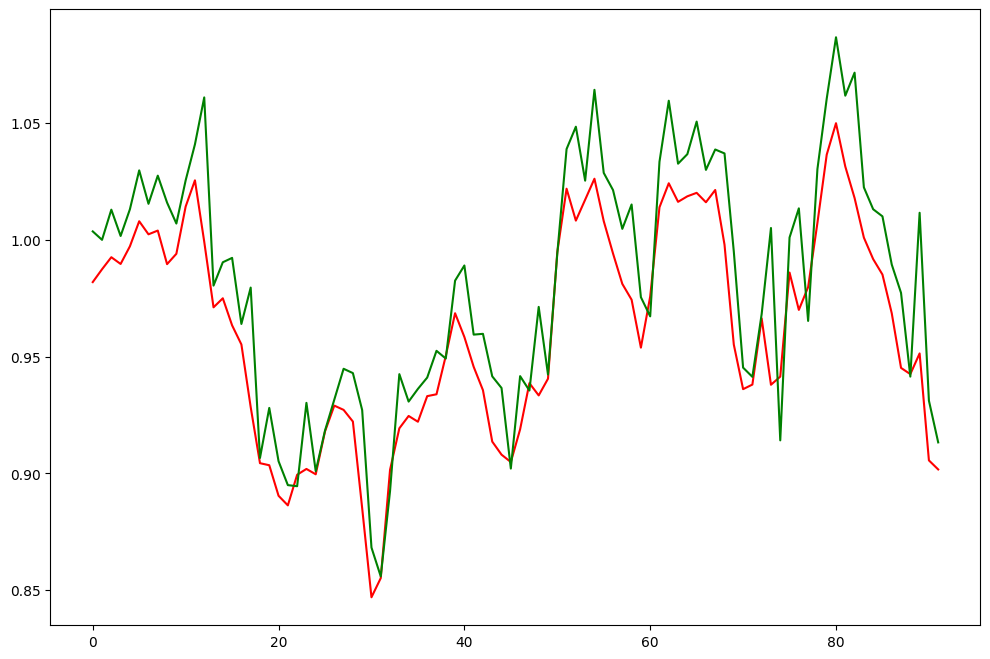

In [301]:
for key in y_test_SM_LSTM:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_LSTM[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [304]:
num_elements = len(next(iter(y_test_SM_LSTM.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(y_test_SM_LSTM[key][i] for key in y_test_SM_LSTM)
    test_LSTM_average.append(element_sum / len(y_test_SM_LSTM))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

In [305]:
test_LSTM_average.shape

(92, 1)

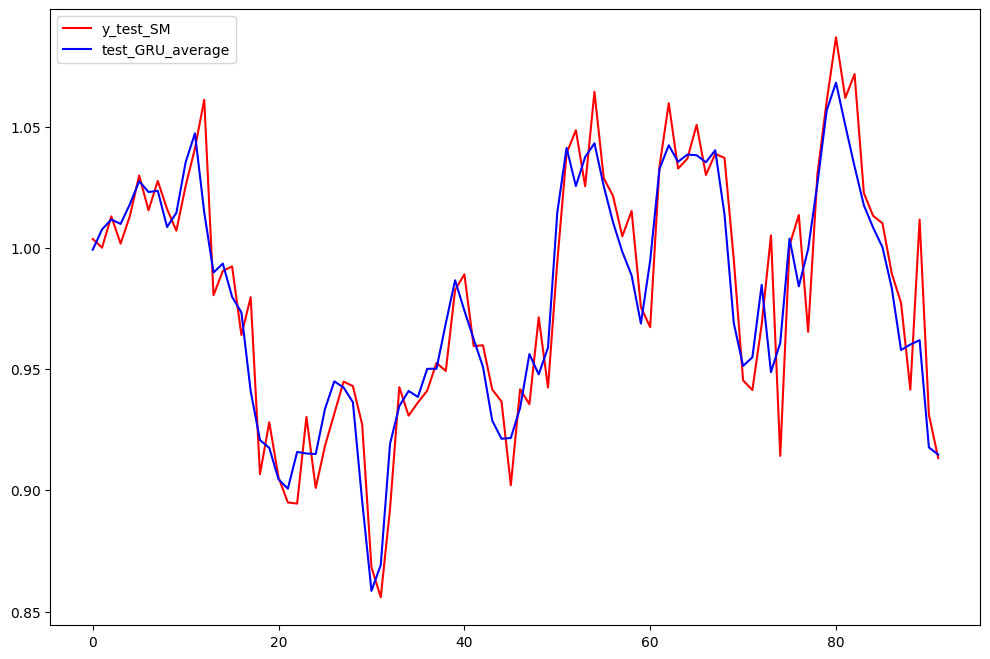

In [330]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_LSTM_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

Train dataset for meta model

In [306]:
train_meta = pd.concat([prediction_LSTM_stacking, prediction_GRU_stacking], axis=1, ignore_index=True)

Test dataset for meta model

In [342]:
test_meta = pd.concat([test_GRU_average,test_LSTM_average],axis=1, ignore_index=True)

meta model training

In [354]:
X_train_meta = train_meta.values
y_train_meta = y_train_SM
X_test_meta  = test_meta.values
y_test_meta  = y_test_SM

In [355]:
print('X train shape of meta model: ', X_train_meta.shape)
print('y train shape of meta model: ',y_train_meta.shape)
print('X test shape of meta model', X_test_meta.shape)
print('y test shape of meta model',y_test_meta.shape)

X train shape of meta model:  (1828, 2)
y train shape of meta model:  (1828,)
X test shape of meta model (92, 2)
y test shape of meta model (92,)


In [356]:
meta_model = LinearRegression()
meta_model.fit(X_train_meta, y_train_meta)

LinearRegression()

In [358]:
meta_model = RandomForestRegressor(n_estimators=500, random_state=42)
meta_model.fit(X_train_meta, y_train_meta)

RandomForestRegressor(n_estimators=500, random_state=42)

In [360]:
y_pred_meta = meta_model.predict(X_test_meta)
mape = mean_absolute_percentage_error(y_test_meta, y_pred_meta)
mae = mean_absolute_error(y_test_meta,y_pred_meta)
mse = mean_squared_error(y_test_meta, y_pred_meta)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.6558809733568148
Mean Absolute Error: 0.6398629236970553
Root Mean Squared Error: 0.6455203136677736


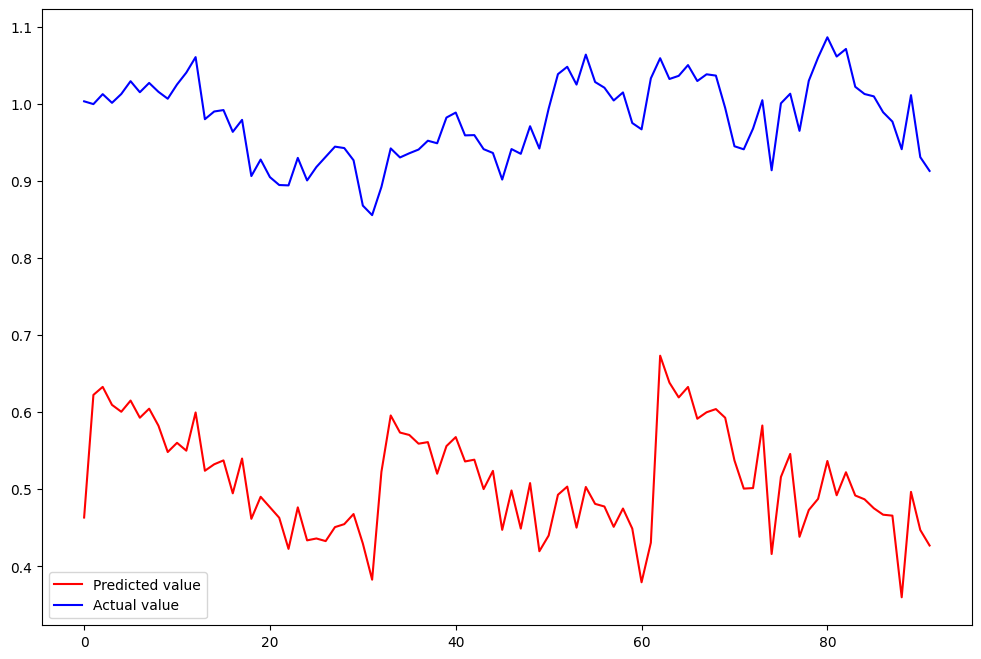

In [340]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_pred_meta.reshape(-1)), color='red', label='Predicted value')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='blue', label='Actual value')
plt.legend()
plt.show()

### ARIMA ###

In [57]:
y_train_ARIMA= y_train_scale

y_test_ARIMA = y_test_scale

y_val_ARIMA = y_val_scale

In [80]:
model_ARIMA = ARIMA(y_train_ARIMA, order=(3, 0, 3)).fit()

d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\USER\anaconda3\envs\e4_jupyter_notebook_assignment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [81]:
pred_test_ARIMA = model_ARIMA.forecast(steps=576)
pred_val_ARIMA = model_ARIMA.forecast(steps=192)

In [82]:
mape = mean_absolute_percentage_error(y_test_ARIMA, pred_test_ARIMA)
mae = mean_absolute_error(y_test_ARIMA,pred_test_ARIMA)
mse = mean_squared_error(y_test_ARIMA, pred_test_ARIMA)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.5194309154281822
Mean Absolute Error: 0.1408187685273725
Root Mean Squared Error: 0.171132947902063


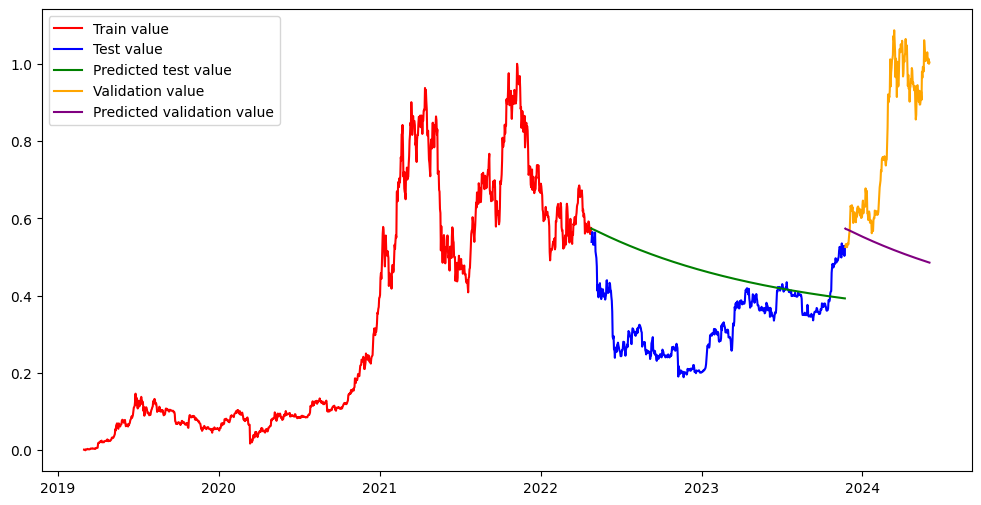

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_ARIMA),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_ARIMA), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_ARIMA), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(y_val_ARIMA),color='orange', label='Validation value')
plt.plot(pd.DataFrame(y_val_scale).index.to_list(),pd.DataFrame(pred_val_ARIMA),color='purple', label='Predicted validation value')
plt.legend()
plt.show()